# Car Sales


In [98]:
import mlflow
import numpy as np
import polars as pl
import seaborn as sns
import xgboost as xgb
from mapie.regression import MapieRegressor
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme()
%matplotlib inline

SEED = 42

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("car-sales")

<Experiment: artifact_location='mlflow-artifacts:/402047761966909601', creation_time=1701306856037, experiment_id='402047761966909601', last_update_time=1701306856037, lifecycle_stage='active', name='car-sales', tags={}>

## Load Data

The data is sourced from the “Car Features and MSRP” dataset on Kaggle.com that was uploaded in 2016. The dataset contains a set of features and the MSRP (Manufacturers Suggested Retail Price) of each car. We will begin by loading the data into a polars dataframe, correcting some datatypes, and looking at the first few rows of the dataset.


In [14]:
df = pl.read_csv("data/raw/car_sales/data.csv")
print("raw shape: ", df.shape)
rename_map = {col: col.lower().replace(" ", "_") for col in df.columns}

df = df.rename(rename_map).with_row_count("id")
df = df.with_columns(
    [
        pl.col(col).str.replace_all(" ", "_").str.to_lowercase()
        for col in df.columns
        if df[col].dtype == pl.Utf8
    ]
).with_columns(
    pl.col(
        "make",
        "model",
        "engine_fuel_type",
        "transmission_type",
        "driven_wheels",
        "vehicle_size",
        "vehicle_style",
    ).cast(pl.Categorical),
)
total_rows = df.shape[0]
df.head()

raw shape:  (11914, 16)


id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,str,cat,cat,i64,i64,i64,i64
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""factory_tuner,…","""compact""","""coupe""",26,19,3916,46135
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""convertible""",28,19,3916,40650
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,high-pe…","""compact""","""coupe""",28,20,3916,36350
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""coupe""",28,18,3916,29450
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury""","""compact""","""convertible""",28,18,3916,34500


## Data Cleaning

### Nulls

One thing that can trip up an analysis is "missing" data. Data can be missing for a variety of reasons. I checked the data entries where there were null entries and found that:

- nulls in the "engine_fuel_type", "engine_hp", and "number_of_doors" columns were likely to actually be missing. These are facts that should be determinable for any kind of car or fuel type.
- nulls in the "engine_cylinders" column weren't missing per se, but rather were a way of indicating that the car had either an electric or rotary engine, neither of which have cylinders.

So, I dropped the rows with null values in the "engine_fuel_type", "engine_hp", and "number_of_doors" columns (total of 73 entries, or about 0.6% of the data), and replaced the null values in the "engine_cylinders" column with 0 as appropriate.


In [15]:
df.describe().filter(pl.col("describe") == "null_count")

describe,id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
str,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,str,f64,f64,f64,f64
"""null_count""",0.0,"""0""","""0""",0.0,"""3""",69.0,30.0,"""0""","""0""",6.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0


In [16]:
count_before = df.shape[0]
df = df.with_columns(
    pl.col("engine_cylinders").fill_null(0)  # rotary and electric engines
).drop_nulls(["engine_fuel_type", "engine_hp", "number_of_doors"])
count_after = df.shape[0]
print(
    f"dropped {count_before - count_after} rows ({(count_before - count_after)/count_before:.2%})"
)

dropped 73 rows (0.61%)


### Poorly Represented Categories

Some categories had very small representation in the dataset, for example the natural gas and electric fuel types. We will filter out categories with less than 1% representation in the dataset, as these categories are likely to be unrepresentative. This removes 104 data entries or about 0.9% of the data.


In [17]:
print_df = (
    df.group_by("engine_fuel_type")
    .agg(pl.count("id").alias("count"))
    .with_columns((pl.col("count") / total_rows))
    .sort("count", descending=True)
    .select(
        pl.col("engine_fuel_type"),
        (pl.col("count") * 100).round(1).alias("percent"),
    )
)
print_df

engine_fuel_type,percent
cat,f64
"""regular_unlead…",60.1
"""premium_unlead…",16.9
"""premium_unlead…",12.7
"""flex-fuel_(unl…",7.5
"""diesel""",1.3
"""flex-fuel_(pre…",0.5
"""flex-fuel_(pre…",0.2
"""electric""",0.2
"""natural_gas""",0.0


dropped 104 rows (0.88%)


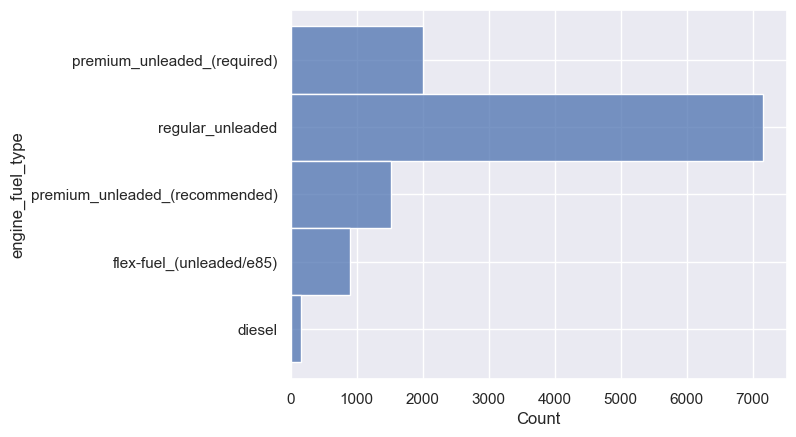

In [18]:
min_count = total_rows * 0.01

count_before = df.shape[0]
value_counts = df.group_by("engine_fuel_type").agg(pl.count("id").alias("count"))
df = (
    df.join(value_counts, on="engine_fuel_type")
    .filter(pl.col("count") >= min_count)
    .drop("count")
)
count_after = df.shape[0]
print(
    f"dropped {count_before - count_after} rows ({(count_before - count_after)/count_before:.2%})"
)

sns.histplot(df, y="engine_fuel_type")
_ = plt.plot()

### Membership of Multiple Categories

In the market_category column, some entries have membership of multiple categories, e.g. 'factory_tuner,luxury,high-performance'. This column can't just be converted to a category, as it will result in far more categories based on teh variety of combinations that are possible. So, we will one-hot-encode membership of each category below.


In [19]:
df_market = (
    (
        df.select("id", "market_category")
        .with_columns([pl.col("market_category").str.split(",")])
        .explode("market_category")
    )
    .pivot(
        index="id",
        values="id",
        columns="market_category",
        aggregate_function="count",
    )
    .fill_null(0)
)
rename_map = {
    col: "market_" + col.lower().replace(" ", "_") if col != "id" else col
    for col in df_market.columns
}
df_market = df_market.rename(rename_map)
df = df.join(df_market, on="id").drop("market_category")
df.head()

id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,market_factory_tuner,market_luxury,market_high-performance,market_performance,market_flex_fuel,market_n/a,market_hatchback,market_hybrid,market_diesel,market_exotic,market_crossover
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,cat,cat,i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",26,19,3916,46135,1,1,1,0,0,0,0,0,0,0,0
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""convertible""",28,19,3916,40650,0,1,0,1,0,0,0,0,0,0,0
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",28,20,3916,36350,0,1,1,0,0,0,0,0,0,0,0
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""coupe""",28,18,3916,29450,0,1,0,1,0,0,0,0,0,0,0
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""compact""","""convertible""",28,18,3916,34500,0,1,0,0,0,0,0,0,0,0,0


### Target Distribution

The target variable, MSRP, is highly skewed. We will log transform it to make it more normally distributed.


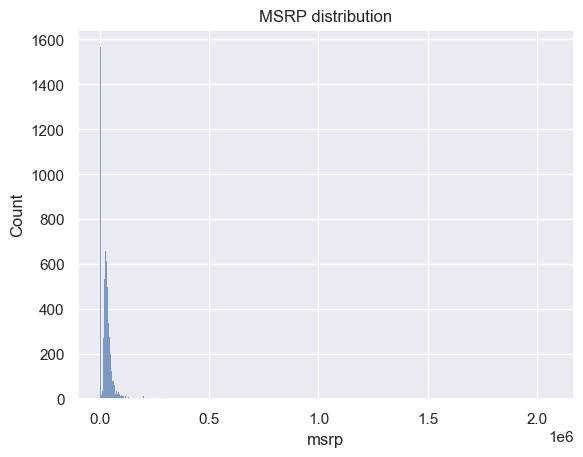

In [20]:
sns.histplot(df, x="msrp")
plt.title("MSRP distribution")
_ = plt.plot()

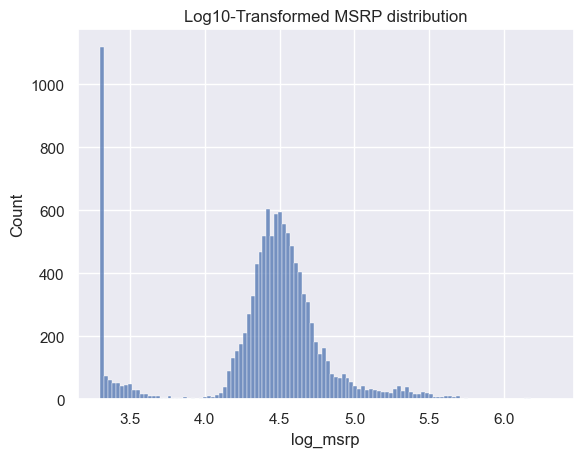

In [21]:
df = df.with_columns(
    pl.col("msrp").log10().alias("log_msrp"),
)
sns.histplot(df, x="log_msrp")
plt.title("Log10-Transformed MSRP distribution")
_ = plt.plot()

## Analysis

Before we start the analysis, we will divide the data into training and test sets. We will use the training set to train the model, and the test set to evaluate the model. We will use 80% of the data for training and 20% for testing.

We will use 2 models to predict the $log_{10}MSRP$ of a car: a linear regression model and an xgboost model. We will use 5-fold cross validation to evaluate the performance of each model. We will use the mean squared error to evaluate the performance of each model. We will also look at the distribution of residuals for each model.


In [116]:
train_percentage = 0.6
valid_percentage = 0.2
train_count = int(df.shape[0] * train_percentage)
valid_count = int(df.shape[0] * valid_percentage)
test_count = df.shape[0] - train_count - valid_count

df = df.sample(fraction=1, shuffle=True, seed=SEED).drop("make", "model")
df_train = df.head(train_count + valid_count)
df_valid = df_train.tail(valid_count)
df_train = df_train.head(train_count)
df_train_X = df_train.drop("id", "msrp", "log_msrp")
df_train_y = df_train.select("log_msrp")
df_valid_X = df_valid.drop("id", "msrp", "log_msrp")
df_valid_y = df_valid.select("log_msrp")

df_test = df.tail(test_count)
df_test_X = df_test.drop("id", "msrp", "log_msrp")
df_test_y = df_test.select("log_msrp")
print(
    "df_train_X: ",
    df_train_X.shape,
    "\ndf_train_y: ",
    df_train_y.shape,
    "\ndf_valid_X: ",
    df_valid_X.shape,
    "\ndf_valid_y: ",
    df_valid_y.shape,
    "\ndf_test_X: ",
    df_test_X.shape,
    "\ndf_test_y: ",
    df_test_y.shape,
)

df_train_X:  (7042, 23) 
df_train_y:  (7042, 1) 
df_valid_X:  (2347, 23) 
df_valid_y:  (2347, 1) 
df_test_X:  (2348, 23) 
df_test_y:  (2348, 1)


### Linear Regression

Linear regression does not handle categorical variables, so we will one-hot-encode the categorical variables. We will use the one-hot-encoded variables as well as the numerical variables as features for the linear regression model.


In [123]:
categorical_columns = [
    name
    for name, dtype in zip(df_train.columns, df_train.dtypes)
    if dtype == pl.Categorical
]
df_train_X_dummies = df_train_X.to_dummies(categorical_columns)

df_valid_X_dummies = df_valid_X.to_dummies(categorical_columns)
missing_columns = set(df_train_X_dummies.columns) - set(df_valid_X_dummies.columns)
for column in missing_columns:
    df_valid_X_dummies = df_valid_X_dummies.with_columns(pl.lit(0).alias(column))
df_valid_X_dummies = df_valid_X_dummies.select(
    df_train_X_dummies.columns
)  # ensure same order

with mlflow.start_run(run_name="valid_metrics"):
    mlflow.set_tag("model", "linear-regression")
    mlflow.log_params({"features": list(df_train_X_dummies.columns)})

    lr_regressor = LinearRegression()
    mapie_regressor = MapieRegressor(estimator=lr_regressor, method="plus", cv=5)
    lr_regressor = lr_regressor.fit(df_train_X_dummies, df_train_y.to_numpy().ravel())
    mapie_regressor = mapie_regressor.fit(
        df_train_X_dummies, df_train_y.to_numpy().ravel()
    )

    y_pred, y_pis = mapie_regressor.predict(df_valid_X_dummies, alpha=[0.05, 0.32])

    mlflow.sklearn.log_model(lr_regressor, "model")

    mse = mean_squared_error(df_valid_y, y_pred)
    rmse = mean_squared_error(df_valid_y, y_pred, squared=False)
    mae = mean_absolute_error(df_valid_y, y_pred)
    r_squared = r2_score(df_valid_y, y_pred)

    mlflow.log_metric("valid_mse", mse)
    mlflow.log_metric("valid_rmse", rmse)
    mlflow.log_metric("valid_mae", mae)
    mlflow.log_metric("valid_r_squared", r_squared)

/Users/seandaly/Library/CloudStorage/OneDrive-Personal/projects/data-science/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/11/29 21:01:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


(0.0, 10000000.0)

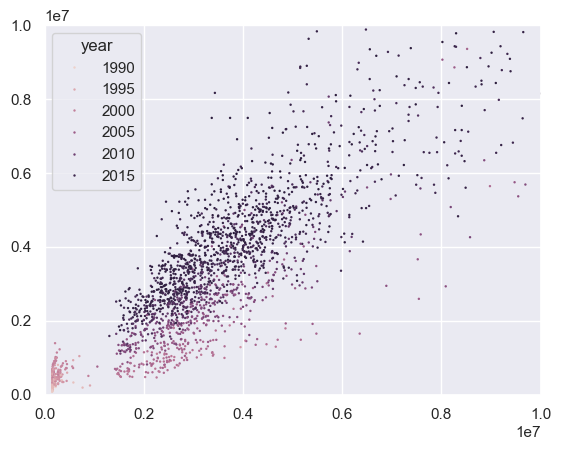

In [127]:
sns.scatterplot(
    x=df_valid_y.to_numpy().ravel() ** 10,
    y=y_pred**10,
    hue=df_valid_X["year"],
    s=3,
    linewidth=0,
)
plt.xlim(0, 10**7)
plt.ylim(0, 10**7)

### XGBoost


In [129]:
with mlflow.start_run(run_name="valid_metrics"):
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params({"features": list(df_train_X_dummies.columns)})

    params = {
        "objective": "reg:squarederror",
        "colsample_bytree": 0.7,
        "learning_rate": 0.1,
        "max_depth": 10,
        "alpha": 20,
        "n_estimators": 100,
    }

    mlflow.log_params(params)
    xgb_regressor = xgb.XGBRegressor(**params)
    mapie_regressor = MapieRegressor(estimator=xgb_regressor, method="plus", cv=5)
    xgb_regressor = xgb_regressor.fit(df_train_X_dummies, df_train_y.to_numpy().ravel())
    mapie_regressor = mapie_regressor.fit(
        df_train_X_dummies, df_train_y.to_numpy().ravel()
    )

    y_pred, y_pis = mapie_regressor.predict(df_valid_X_dummies, alpha=[0.05, 0.32])

    mlflow.xgboost.log_model(xgb_regressor, "model")

    mse = mean_squared_error(df_valid_y, y_pred)
    rmse = mean_squared_error(df_valid_y, y_pred, squared=False)
    mae = mean_absolute_error(df_valid_y, y_pred)
    r_squared = r2_score(df_valid_y, y_pred)

    mlflow.log_metric("valid_mse", mse)
    mlflow.log_metric("valid_rmse", rmse)
    mlflow.log_metric("valid_mae", mae)
    mlflow.log_metric("valid_r_squared", r_squared)

/Users/seandaly/Library/CloudStorage/OneDrive-Personal/projects/data-science/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/Users/seandaly/Library/CloudStorage/OneDrive-Personal/projects/data-science/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/11/29 21:05:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


(0.0, 10000000.0)

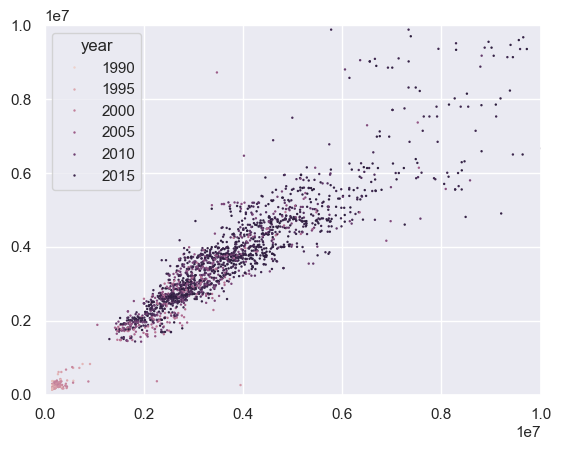

In [130]:
sns.scatterplot(
    x=df_valid_y.to_numpy().ravel() ** 10,
    y=y_pred**10,
    hue=df_valid_X["year"],
    s=3,
    linewidth=0,
)
plt.xlim(0, 10**7)
plt.ylim(0, 10**7)

## References

“Car Features and MSRP” (2016), Kaggle.com, available at https://www.kaggle.com/datasets/CooperUnion/cardataset (accessed November 29, 2023).
